# Pairs trading

**Objective**

Find pairs of stock from an ETF that are negatively correlated and build a strategy using pair trading to make profit

In [3]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

In [4]:
xlk_stocks = [
    "AAPL",    # Apple Inc.
    "MSFT",    # Microsoft Corporation
    "NVDA",    # NVIDIA Corporation
    "AVGO",    # Broadcom Inc.
    "AMD",     # Advanced Micro Devices, Inc.
    "ADBE",    # Adobe Inc.
    "CRM",     # Salesforce, Inc.
    "ORCL",    # Oracle Corporation
    "CSCO",    # Cisco Systems, Inc.
    "ACN",     # Accenture plc
    "IBM",     # International Business Machines Corporation
    "INTC",    # Intel Corporation
    "QCOM",    # QUALCOMM Incorporated
    "TXN",     # Texas Instruments Incorporated
    "AMAT",    # Applied Materials, Inc.
    "INTU",    # Intuit Inc.
    "NOW",     # ServiceNow, Inc.
    "ADI",     # Analog Devices, Inc.
    "MU",      # Micron Technology, Inc.
    "LRCX",    # Lam Research Corporation
    "SNPS",    # Synopsys, Inc.
    "CDNS",    # Cadence Design Systems, Inc.
    "KLAC",    # KLA Corporation
    "ADSK",    # Autodesk, Inc.
    "PYPL",    # PayPal Holdings, Inc.
    "TEL",     # TE Connectivity Ltd.
    "NXPI",    # NXP Semiconductors N.V.
    "ANET",    # Arista Networks, Inc.
    "PANW",    # Palo Alto Networks, Inc.
    "MSI",     # Motorola Solutions, Inc.
    "FTNT",    # Fortinet, Inc.
    "CTSH",    # Cognizant Technology Solutions Corporation
    "APH",     # Amphenol Corporation
    "ANSS",    # ANSYS, Inc.
    "MCHP",    # Microchip Technology Incorporated
    "VRSN",    # VeriSign, Inc.
    "GLW",     # Corning Incorporated
    "MPWR",    # Monolithic Power Systems, Inc.
    "KEYS",    # Keysight Technologies, Inc.
    "AKAM",    # Akamai Technologies, Inc.
    "HPE",     # Hewlett Packard Enterprise Company
    "DAY",    # Ceridian HCM Holding Inc.
    "TER",     # Teradyne, Inc.
    "PTC",     # PTC Inc.
    "NTAP",    # NetApp, Inc.
    "IT",      # Gartner, Inc.
    "BR",      # Broadridge Financial Solutions, Inc.
    "TYL",     # Tyler Technologies, Inc.
    "JNPR",    # Juniper Networks, Inc.
    "STX",     # Seagate Technology Holdings plc
    "TRMB",    # Trimble Inc.
    "CDW",     # CDW Corporation
    "WDC",     # Western Digital Corporation
    "ZBRA",    # Zebra Technologies Corporation
    "DXC",     # DXC Technology Company
    "FICO",    # Fair Isaac Corporation
    "FFIV",    # F5, Inc.
    "EPAM",    # EPAM Systems, Inc.
    "HPQ",     # HP Inc.
    "LDOS",    # Leidos Holdings, Inc.
    "FSLR",    # First Solar, Inc.
    "GEN",     # Gen Digital Inc.
    "JKHY",    # Jack Henry & Associates, Inc.
    "SWKS"     # Skyworks Solutions, Inc.
]
# Define the start and end dates for the last 10 years
start_date = datetime.datetime.now() - datetime.timedelta(days=365 * 10)
end_date = datetime.datetime.now()
# Extract price history for the last 10 years for the top 20 tickers
stock_data = {}
for ticker in xlk_stocks:
    stock = yf.Ticker(ticker)
    stock_data[ticker] = stock.history(start=start_date, end=end_date)

xlk_etf = yf.Ticker("XLK")
xlk_data = xlk_etf.history(start=start_date, end=end_date)
spy= yf.Ticker("SPY")
spy_data = spy.history(start=start_date, end=end_date)

In [5]:
# Combine the data into a single DataFrame
price_history = {ticker: data['Close'] for ticker, data in stock_data.items()}
price_history_df = pd.DataFrame(price_history)
# Calculate daily returns
daily_returns = price_history_df.pct_change()
daily_returns.dropna(inplace=True)
daily_returns.head()

,AAPL,MSFT,NVDA,AVGO,AMD,ADBE,CRM,ORCL,CSCO,ACN,...,DXC,FICO,FFIV,EPAM,HPQ,LDOS,FSLR,GEN,JKHY,SWKS
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-27 00:00:00-04:00,-0.011570,0.016550,0.004928,0.010242,0.006341,-0.000045,-0.005048,-0.009356,0.011310,0.000656,...,-0.001255,0.036033,0.014955,-0.000870,0.006052,0.002591,0.038226,-0.029330,-0.013146,-0.014932
2018-04-30 00:00:00-04:00,0.018112,-0.024004,-0.006318,-0.014434,-0.020702,-0.001352,0.006405,0.003074,-0.009394,-0.007809,...,-0.004059,-0.019033,0.013989,-0.003746,-0.005553,-0.023563,-0.090314,-0.000360,-0.005245,-0.003675
2018-05-01 00:00:00-04:00,0.023236,0.015826,0.009960,0.004184,0.022978,0.011191,0.017522,0.006131,0.012192,0.004762,...,-0.002717,0.006929,0.009688,0.005509,0.015356,-0.011677,-0.047948,-0.004318,0.016321,0.047718
2018-05-02 00:00:00-04:00,0.044175,-0.015684,-0.003654,-0.007119,-0.014376,-0.013299,-0.002356,-0.009576,-0.021637,-0.007964,...,-0.010800,-0.017949,0.006376,-0.003827,-0.012374,-0.022684,0.007554,0.009035,-0.028823,0.005060
2018-05-03 00:00:00-04:00,0.001812,0.005989,0.029517,-0.015258,-0.003646,0.022388,0.012946,-0.009888,0.013224,0.006768,...,-0.004524,0.013664,0.015689,0.003667,-0.010673,-0.028530,-0.029991,-0.006805,0.024845,0.009742


In [6]:
# Define the new 2-year window
tickers = xlk_stocks
two_years_start = datetime.datetime(2022, 1, 1, tzinfo=daily_returns.index.tz)
two_years_end = datetime.datetime(2024, 1, 1, tzinfo=daily_returns.index.tz)
daily_returns_2y = daily_returns[(daily_returns.index >= two_years_start) & (daily_returns.index < two_years_end)]

# Calculate the covariance matrix for the past 2 years
covariance_matrix_2y = daily_returns_2y.cov()

# Perform PCA on the new covariance matrix
pca_2y = PCA()
pca_2y.fit(covariance_matrix_2y)

# Get the eigenvalues (explained variance) for the past 2 years
eigenvalues_2y = pca_2y.explained_variance_

# Extract the first two eigenvectors for the past 2 years
pca_2y_1 = pca_2y.components_[0]
pca_2y_2 = pca_2y.components_[1]

# Find pairs of stocks with opposite signs in pca_2y_2
pairs = []
for i in range(len(pca_2y_2)):
    for j in range(i + 1, len(pca_2y_2)):
        if np.sign(pca_2y_2[i]) != np.sign(pca_2y_2[j]):
            diff_1 = abs((pca_2y_1[i] - pca_2y_1[j])/pca_2y_1[j]) #distance in pca_1
            diff_2 = abs((abs(pca_2y_2[i]) - abs(pca_2y_2[j]))/pca_2y_2[j]) #distance in pca_2
            diff=3*diff_1+2*diff_2 #I give slightly more weight to distance in pca_1
            pairs.append(((tickers[i], tickers[j]), diff))

#pairs sorted according to some combination of distance in pca_1 and pca_2
pairs_sorted = sorted(pairs, key=lambda x: x[1])

# Display the ranked pairs
for pair, diff in pairs_sorted:
    print(f"Pair: {pair}, Absolute Difference: {diff:.6f}")

Pair: ('MSFT', 'TXN'), Absolute Difference: 0.109865
Pair: ('MU', 'DAY'), Absolute Difference: 0.288607
Pair: ('PYPL', 'WDC'), Absolute Difference: 0.312213
Pair: ('FTNT', 'WDC'), Absolute Difference: 0.368910
Pair: ('CDNS', 'SWKS'), Absolute Difference: 0.391701
Pair: ('SNPS', 'SWKS'), Absolute Difference: 0.414659
Pair: ('ORCL', 'JNPR'), Absolute Difference: 0.416228
Pair: ('INTC', 'ANSS'), Absolute Difference: 0.480109
Pair: ('TEL', 'FSLR'), Absolute Difference: 0.509552
Pair: ('CRM', 'WDC'), Absolute Difference: 0.527770
Pair: ('SNPS', 'MCHP'), Absolute Difference: 0.531240
Pair: ('INTC', 'TYL'), Absolute Difference: 0.540088
Pair: ('QCOM', 'SNPS'), Absolute Difference: 0.551024
Pair: ('ADBE', 'INTC'), Absolute Difference: 0.565959
Pair: ('INTU', 'WDC'), Absolute Difference: 0.579155
Pair: ('MSI', 'JNPR'), Absolute Difference: 0.579268
Pair: ('INTU', 'MU'), Absolute Difference: 0.582688
Pair: ('SNPS', 'NXPI'), Absolute Difference: 0.593481
Pair: ('QCOM', 'CDNS'), Absolute Differenc

In [7]:
#find stocks in the top pairs that are not repeated
used_stocks = set()
largest_N = 0

# Iterate through the sorted pairs
for i, (pair, _) in enumerate(pairs_sorted):
    stock1, stock2 = pair

    # Check if the stocks are already used, except in the previous row
    if stock1 in used_stocks or stock2 in used_stocks:
        if i > 0 and (stock1 in pairs_sorted[i - 1][0] or stock2 in pairs_sorted[i - 1][0]):
            # Allow repetition only in adjacent rows
            pass
        else:
            break

    # Add stocks to the used set
    used_stocks.add(stock1)
    used_stocks.add(stock2)

    # Increment the count
    largest_N += 1

print(f"The largest N is: {largest_N}")

#flatten the pairs and remove repeated stocks
top_pairs = [pair for pair, _ in pairs_sorted[:largest_N]]
top_stocks = []
for pair in top_pairs:
    for stock in pair:
        if stock not in top_stocks:
            top_stocks.append(stock)

# Extract the indices for top stocks and remaining stocks
top_indices = [tickers.index(stock) for stock in top_stocks]
remaining_indices = [i for i, ticker in enumerate(tickers) if ticker not in top_stocks]

# Combine the indices to create the new order
new_order = top_indices + remaining_indices
tickers_reordered = [tickers[i] for i in new_order]
# tickers_reordered

The largest N is: 9


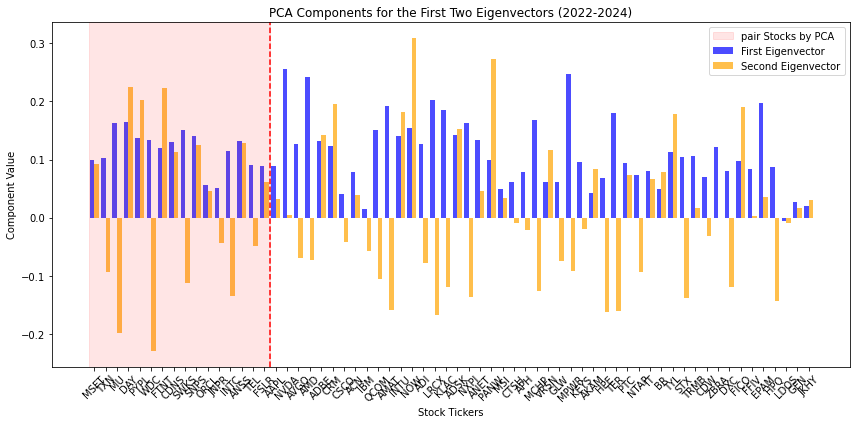

In [8]:
# Reorder the PCA components and tickers
pca_2y_1_reordered = pca_2y_1[new_order]
pca_2y_2_reordered = pca_2y_2[new_order]

# Plot the components as a histogram
x_reordered = np.arange(len(tickers_reordered))
plt.figure(figsize=(12, 6))
plt.bar(x_reordered - 0.2, pca_2y_1_reordered, width=0.4, label="First Eigenvector", color='blue', alpha=0.7)
plt.bar(x_reordered + 0.2, pca_2y_2_reordered, width=0.4, label="Second Eigenvector", color='orange', alpha=0.7)
plt.axvline(x=len(top_stocks) - 0.5, color='red', linestyle='--')
plt.axvspan(-0.5, len(top_stocks) - 0.5, color='red', alpha=0.1, label="pair Stocks by PCA")
plt.xticks(x_reordered, tickers_reordered, rotation=45)
plt.xlabel("Stock Tickers")
plt.ylabel("Component Value")
plt.title(f"PCA Components for the First Two Eigenvectors ({two_years_start.year}-{two_years_end.year})")
plt.legend()
plt.tight_layout()
plt.show()

As ANET and FTNT have opposite weights in pca_2 but roughly same weights in pca_1, they might be anti-correlated after adjusting for broader market movements in technology sector.

In [9]:
# Extract daily returns for the top 10 pairs and check their cointegration
# Ensure the time range matches the PCA analysis time range
# Initialize variables to track the pair with the smallest p-value
min_pvalue = float('inf')
best_pair = None

for pair, _ in pairs_sorted[:10]:
    stock1, stock2 = pair
    stock1_close = price_history[stock1][(price_history[stock1].index >= two_years_start) & (price_history[stock1].index < two_years_end)]
    stock2_close = price_history[stock2][(price_history[stock2].index >= two_years_start) & (price_history[stock2].index < two_years_end)]
    score, pvalue, critical_values = coint(stock1_close, stock2_close)
    print(f"Pair: {stock1} & {stock2}, Cointegration test p-value: {pvalue:.7f}")
    
    # Update the pair with the smallest p-value
    if pvalue < min_pvalue:
        min_pvalue = pvalue
        best_pair = (stock1, stock2)

print(f"\nStock pair with the smallest p-value: {best_pair}, p-value: {min_pvalue:.7f}")

Pair: MSFT & TXN, Cointegration test p-value: 0.9767938
Pair: MU & DAY, Cointegration test p-value: 0.7658193
Pair: PYPL & WDC, Cointegration test p-value: 0.0105257
Pair: FTNT & WDC, Cointegration test p-value: 0.1419316
Pair: CDNS & SWKS, Cointegration test p-value: 0.9733991
Pair: SNPS & SWKS, Cointegration test p-value: 0.9599846
Pair: ORCL & JNPR, Cointegration test p-value: 0.8936761
Pair: INTC & ANSS, Cointegration test p-value: 0.8727878
Pair: TEL & FSLR, Cointegration test p-value: 0.0485648
Pair: CRM & WDC, Cointegration test p-value: 0.8665924

Stock pair with the smallest p-value: ('PYPL', 'WDC'), p-value: 0.0105257


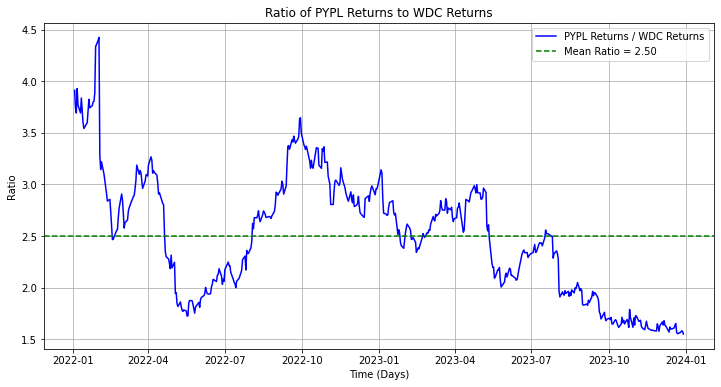

In [10]:
# Calculate the ratio of ANET returns to FTNT returns
# Extract the stock pair with the smallest p-value for cointegration
stock1, stock2 = best_pair

# Get the closing prices for the two stocks within the two-year window
stock1_close = price_history[stock1][(price_history[stock1].index >= two_years_start) & (price_history[stock1].index < two_years_end)]
stock2_close = price_history[stock2][(price_history[stock2].index >= two_years_start) & (price_history[stock2].index < two_years_end)]

# Calculate the ratio of their returns
ratio = stock1_close / stock2_close

# Plot the ratio
plt.figure(figsize=(12, 6))
plt.plot(ratio, label=f"{stock1} Returns / {stock2} Returns", color="blue")
plt.axhline(y=ratio.mean(), color="green", linestyle="--", label=f"Mean Ratio = {ratio.mean():.2f}")
plt.xlabel("Time (Days)")
plt.ylabel("Ratio")
plt.title(f"Ratio of {stock1} Returns to {stock2} Returns")
plt.legend()
plt.grid()
plt.show()

In [22]:
def zscore(dates, stock1, stock2, window):
    if isinstance(dates, pd.Timestamp):  # If a single date is passed
        dates = [dates]  # Convert it to a list

    zscores = []
    for date in dates:
        # Calculate ratio of stocks in the past 'window' days
        ratio = price_history[stock1][(price_history[stock1].index >= date - datetime.timedelta(days=window)) & (price_history[stock1].index < date)] / \
                price_history[stock2][(price_history[stock2].index >= date - datetime.timedelta(days=window)) & (price_history[stock2].index < date)]
        mean = ratio.mean()
        std = ratio.std()

        # Calculate the z-score
        zscores.append((ratio.iloc[-1] - mean) / std)
    
    return np.array(zscores) if len(zscores) > 1 else zscores[0]

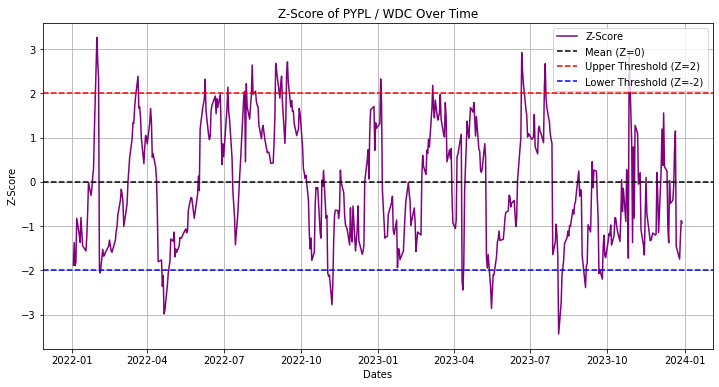

In [94]:
window=30 #number of days used to calculate z-score
dates = price_history[stock1][(price_history[stock1].index >= two_years_start) & (price_history[stock1].index < two_years_end)].index
score=zscore(dates, stock1, stock2, window)
plt.figure(figsize=(12, 6))
plt.plot(dates, score, label="Z-Score", color="purple")
plt.axhline(y=0, color="black", linestyle="--", label="Mean (Z=0)")
plt.axhline(y=2, color="red", linestyle="--", label="Upper Threshold (Z=2)")
plt.axhline(y=-2, color="blue", linestyle="--", label="Lower Threshold (Z=-2)")
plt.xlabel("Dates")
plt.ylabel("Z-Score")
plt.title(f"Z-Score of {stock1} / {stock2} Over Time")
plt.legend()
plt.grid()
plt.show()

In [27]:
class stock:
    def __init__(self, ticker):
        self.ticker = ticker
        self.history  = []
        self.long_position = 0
        self._long_history = np.zeros([0, 2])
        self.short_postion=0
        self._short_history = np.zeros([0,2])
        self.invested=0
        self.realized_profit = 0.0

    def _subtract_from_array(self, arr, X):
        arr = np.array(arr, dtype=float)  # Ensure the array is a NumPy array and supports float operations
        cumulative_sum = np.cumsum(arr[:,0])  # Compute the cumulative sum of the array
        remaining = cumulative_sum - X   # Subtract X from the cumulative sum

        # print(arr,X)
        if remaining[-1]>0:
            # Find where the remaining amount becomes non-positive
            zeroed_indices = remaining <= 0
            #calculatenet money invested on the sold shares
            net_invested = arr[zeroed_indices,0].T@arr[zeroed_indices,1]
            # Update the array based on the remaining amount
            arr = arr[~zeroed_indices]
            net_invested+= (arr[0,0]-remaining[~zeroed_indices][0])*arr[0,1]
            arr[0,0] = remaining[~zeroed_indices][0]
        else:
            net_invested=arr[:,0].T@arr[:,1]
            arr=np.zeros([0, 2])
        # print(arr)
        return (arr,net_invested)
    
    def buy(self, date, amount):
        self.history.append((price_history[self.ticker][date], amount, +1))        
        shorted=min(self.short_postion, amount)
        bought=amount-shorted
        
        if shorted>0:
            self._short_history, net_borrowed = self._subtract_from_array(self._short_history, shorted) #remove the number of shorted shares from previous short history
            self.realized_profit += net_borrowed - shorted * price_history[self.ticker][date] #profit from buying the shorted shares
            self.short_postion -= shorted

        self._long_history=np.append(self._long_history,np.array([[bought,price_history[self.ticker][date]]]), axis=0) #append the new buy to the long history
        self.long_position += bought

        self.invested += amount * price_history[self.ticker][date] #shorted shares also count towards investing because they cancel out the negative sum we invested in the begining
        
    
    def sell(self, date, amount):
        self.history.append((price_history[self.ticker][date], amount, -1))
        long_sold = min(self.long_position, amount)
        shorted = amount - long_sold

        if long_sold > 0:
            self._long_history, net_invested = self._subtract_from_array(self._long_history, long_sold)  # Remove the number of sold shares from previous long history
            self.realized_profit += long_sold * price_history[self.ticker][date] - net_invested  # Profit from selling the long shares
            self.long_position -= long_sold

        self._short_history = np.append(self._short_history, np.array([[shorted, price_history[self.ticker][date]]]), axis=0)  # Append the new short to the short history
        self.short_postion += shorted

        self.invested -= amount * price_history[self.ticker][date] #invested amount can go negative if we are shorting as we are borrowing money.

    def close(self,date):
        if self.long_position > 0:
            self.sell(date, self.long_position)
        if self.short_postion > 0:  
            self.buy(date, self.short_postion)
        pass
    
    def unrealized_profit(self, date):
        # Calculate unrealized profit based on the current price and the invested amount
        current_price = price_history[self.ticker][date]
        profit = self._long_history[:,0].T@(current_price-self._long_history[:,1])
        profit += self._short_history[:,0].T@(self._short_history[:,1]-current_price)
        
        return profit


In [51]:
STK = stock(stock1)
STK.buy(dates[0], 10)
STK.buy(dates[1], 10)
STK.sell(dates[2], 25)
STK.buy(dates[15], 2)
STK.close(dates[30])
print(STK.history)
print(STK.invested,STK.long_position,STK.short_postion,STK.realized_profit, STK.unrealized_profit(dates[16]))

[(np.float64(194.94000244140625), 10, 1), (np.float64(191.13999938964844), 10, 1), (np.float64(187.16000366210938), 25, -1), (np.float64(158.1999969482422), 2, 1), (np.float64(115.45999908447266), 3, 1)]
-155.42008209228516 0 0 155.42008209228516 0.0


In [68]:
temp=stock(stock1)
temp.buy(dates[0], 10)
print(price_history[stock1][dates[0]])
print(price_history[stock1][dates[2]],temp.unrealized_profit(dates[2]))
temp.close(dates[2])
print(price_history[stock1][dates[2]],temp.unrealized_profit(dates[2]),temp.realized_profit)
temp.buy(dates[15], 10)
print(price_history[stock1][dates[15]])
print(price_history[stock1][dates[19]],temp.unrealized_profit(dates[19]),temp.realized_profit)
temp.close(dates[19])
print(price_history[stock1][dates[19]],temp.unrealized_profit(dates[19]),temp.realized_profit)

194.94000244140625
187.16000366210938 -77.79998779296875
187.16000366210938 0.0 -77.79998779296875
158.1999969482422
171.94000244140625 137.40005493164062 -77.79998779296875
171.94000244140625 0.0 59.600067138671875


In [18]:
# Calculate daily returns for SPY and XLK
spy_daily_returns = spy_data['Close'].pct_change().dropna()
xlk_daily_returns = xlk_data['Close'].pct_change().dropna()
def calculate_beta(stock, date, window):
    # Add a constant for the intercept in the regression
    stock_returns = daily_returns[stock][(daily_returns.index >= date - datetime.timedelta(days=window)) & (daily_returns.index < date)]
    benchmark_returns = spy_daily_returns[(spy_daily_returns.index >= date - datetime.timedelta(days=window)) & (spy_daily_returns.index < date)]
    X = sm.add_constant(benchmark_returns)
    model = sm.OLS(stock_returns, X).fit()
    return model.params.iloc[1]  # Use iloc to access the beta value (slope) by position

In [19]:
calculate_beta(STK.ticker,dates[70],60)

np.float64(2.0877914018733215)

In [80]:
def pair_trade(dates,STK1,STK2,window,z_threshold):
    # Initialize variables to track realized profit at every closing
    profit=[]
    unrealized_profit=np.zeros(len(dates))
    # Initialize a list to store the trade history
    trade_history = []

    i=0
    for date in dates:
        # Calculate the z-score for the current date
        zscore_value = zscore(date, STK1.ticker, STK2.ticker, window)
        unrealized_profit[i] = STK1.unrealized_profit(date) + STK2.unrealized_profit(date)

        # Check if the sign of z-score changes from the previous date
        if len(trade_history) > 0 and (np.sign(zscore_value) != np.sign(zscore(dates[dates.get_loc(date) - 1], STK1.ticker, STK2.ticker, window)) or date == dates[-1]):
            profit.append(STK1.unrealized_profit(date) + STK2.unrealized_profit(date))
            STK1.close(date)
            STK2.close(date)
            trade_history.append((date, "Close", profit[-1],"Close", profit[-1]))
        
        # Check if the z-score exceeds the threshold for buying or selling
        if zscore_value > z_threshold and date<dates[-1]:
            beta1=calculate_beta(STK1.ticker, date, window)
            beta2=calculate_beta(STK2.ticker, date, window)
            # Calculate the amount to invest based on the hedge ratio
            amount1 = 100 * beta1 / (beta1 + beta2) / price_history[STK1.ticker][date]
            amount2 = 100 * beta2 / (beta1 + beta2) / price_history[STK2.ticker][date]
            # Short STK1 and long STK2
            STK1.sell(date, amount1)
            STK2.buy(date, amount2)
            trade_history.append((date, "Short", amount1, "long", amount2))

        elif zscore_value < -z_threshold and date<dates[-1]:
            beta1=calculate_beta(STK1.ticker, date, window)
            beta2=calculate_beta(STK2.ticker, date, window)
            # Calculate the amount to invest based on the hedge ratio
            amount1 = 100 * beta1 / (beta1 + beta2) / price_history[STK1.ticker][date]
            amount2 = 100 * beta2 / (beta1 + beta2) / price_history[STK2.ticker][date]
            # Long STK1 and short STK2
            STK1.buy(date, amount1)
            STK2.sell(date, amount2)
            trade_history.append((date, "Long", amount1, "short", amount2))
        
        i=i+1

    return trade_history, profit, unrealized_profit

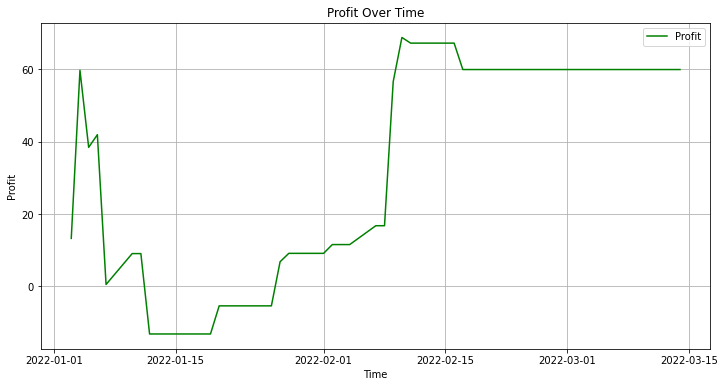

In [113]:
trade_history, profit, unrealized_profit = pair_trade(dates, stock(stock1), stock(stock2), window=40, z_threshold=2)
# Generate a time series for the profit data
profit_dates = dates[:len(profit)]  # Ensure the length matches the profit list
# Calculate net profit as the cumulative sum of profit
net_profit = np.cumsum(profit)
# Plot the profit over time
plt.figure(figsize=(12, 6))
plt.plot(profit_dates, net_profit, label="Profit", color="green")
plt.xlabel("Time")
plt.ylabel("Profit")
plt.title("Profit Over Time")
plt.legend()
plt.grid()
plt.show()

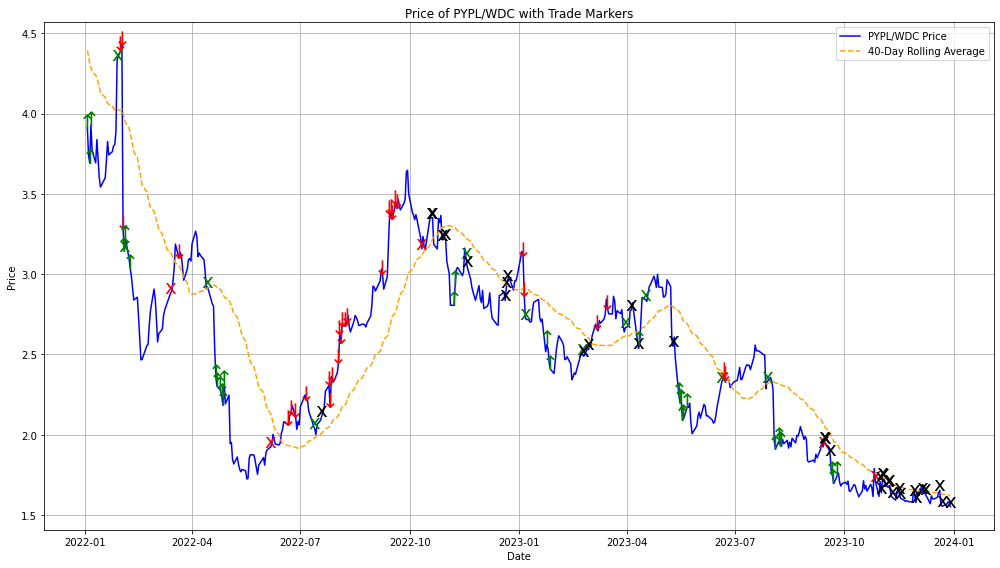

In [122]:
# Plot the price of stock1 and stock2
plt.figure(figsize=(14, 8))

# Plot stock1/stock2 prices
plt.plot(stock1_close.index, stock1_close/stock2_close, label=f"{stock1}/{stock2} Price", color="blue")
# Calculate and plot the 40-day rolling average of stock1/stock2
rolling_avg = (price_history[stock1] / price_history[stock2]).rolling(window=40).mean().loc[stock1_close.index]
plt.plot(stock1_close.index, rolling_avg, label="40-Day Rolling Average", color="orange", linestyle="--")
# Add markers for trade history
for entry in trade_history:
    date, action, value1, _, value2 = entry
    if action == "Long":
        # Green up arrow for stock1 and red down arrow for stock2
        plt.annotate("↑", (date, stock1_close[date]/stock2_close[date]), color="green", fontsize=20, ha="center")
        # plt.annotate("↓", (date, stock2_close[date]), color="red", fontsize=12, ha="center")
    elif action == "Short":
        # Red down arrow for stock1 and green up arrow for stock2
        plt.annotate("↓", (date, stock1_close[date]/stock2_close[date]), color="red", fontsize=20, ha="center")
        # plt.annotate("↑", (date, stock2_close[date]), color="green", fontsize=12, ha="center")
    elif action == "Close":
        # Cross mark for both stocks
        color = "green" if value1 > 0 else "red" if value1 < 0 else "black"
        plt.annotate("x", (date, stock1_close[date]/stock2_close[date]), color=color, fontsize=20, ha="center")
        # plt.annotate("x", (date, stock2_close[date]), color=color, fontsize=12, ha="center")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Price")
plt.title(f"Price of {stock1}/{stock2} with Trade Markers")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

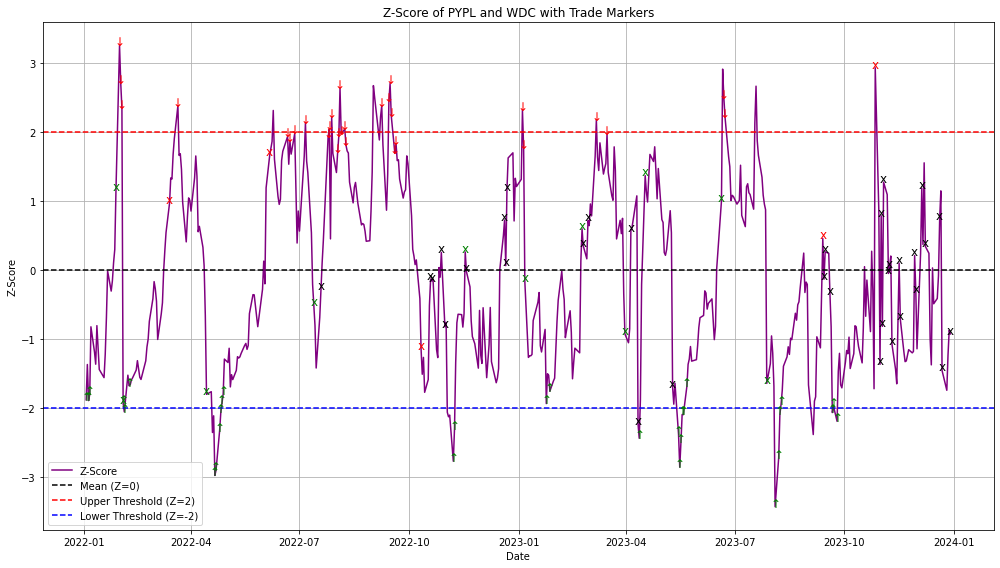

In [110]:
# Plot the z-score of stock1 and stock2
plt.figure(figsize=(14, 8))

# Calculate z-scores for all dates
z_scores = zscore(dates, stock1, stock2, window)

# Plot the z-scores
plt.plot(dates, z_scores, label="Z-Score", color="purple")
plt.axhline(y=0, color="black", linestyle="--", label="Mean (Z=0)")
plt.axhline(y=2, color="red", linestyle="--", label="Upper Threshold (Z=2)")
plt.axhline(y=-2, color="blue", linestyle="--", label="Lower Threshold (Z=-2)")

# Add markers for trade history
for entry in trade_history:
    date, action, value1, _, value2 = entry
    if action == "Long":
        # Green up arrow
        plt.annotate("↑", (date, zscore(date, stock1, stock2, window)), color="green", fontsize=12, ha="center")
    elif action == "Short":
        # Red down arrow
        plt.annotate("↓", (date, zscore(date, stock1, stock2, window)), color="red", fontsize=12, ha="center")
    elif action == "Close":
        # Cross mark
        color = "green" if value1 > 0 else "red" if value1 < 0 else "black"
        plt.annotate("x", (date, zscore(date, stock1, stock2, window)), color=color, fontsize=12, ha="center")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.title(f"Z-Score of {stock1} and {stock2} with Trade Markers")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

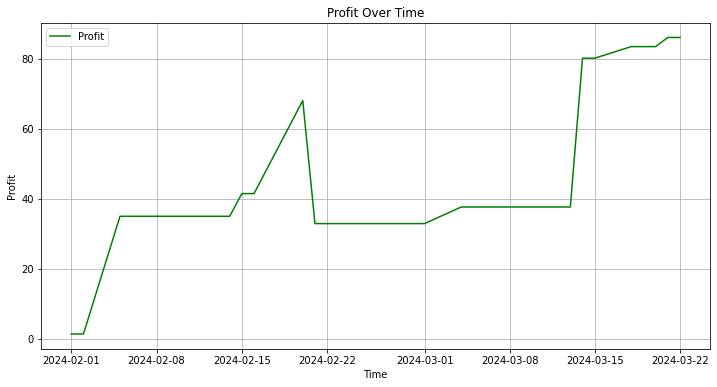

In [112]:
test_years_start = datetime.datetime(2024, 2, 1, tzinfo=daily_returns.index.tz)
test_years_end = datetime.datetime(2025, 2, 1, tzinfo=daily_returns.index.tz)
dates2 = price_history[stock1][(price_history[stock1].index >= test_years_start) & (price_history[stock1].index < test_years_end)].index
trade_history2, profit2, unrealized_profit2 = pair_trade(dates2, stock(stock1), stock(stock2), window=40, z_threshold=2)
# Generate a time series for the profit data
profit_dates = dates2[:len(profit2)]  # Ensure the length matches the profit list
# Calculate net profit as the cumulative sum of profit
net_profit = np.cumsum(profit2)
# Plot the profit over time
plt.figure(figsize=(12, 6))
plt.plot(profit_dates, net_profit, label="Profit", color="green")
plt.xlabel("Time")
plt.ylabel("Profit")
plt.title("Profit Over Time")
plt.legend()
plt.grid()
plt.show()